## Multi-agent supervisor
Supervisor is a multi-agent architecture where specialized agents are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

We will build a supervisor system with two agents — a research and a math expert. By the end of the Section you will:
1. Build specialized research and math agents

2. Build a supervisor for orchestrating them with the prebuilt langgraph-supervisor

3. Build a supervisor from scratch

4. Implement advanced task delegation

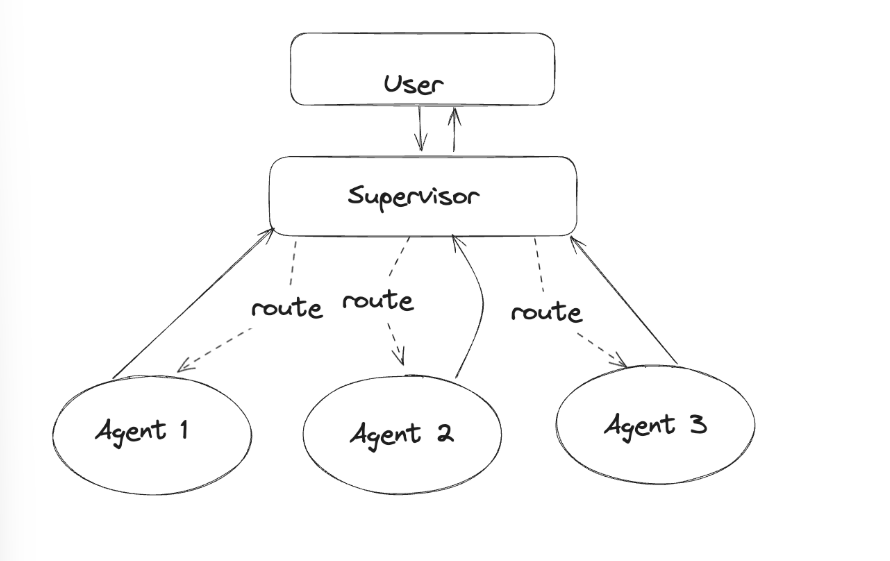

In [10]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

model = ChatGroq(model="qwen/qwen3-32b")

## 1. Create worker agents
First, let's create our specialized worker agents — research agent and math agent:

- Research agent will have access to a web search tool using Tavily API
- Math agent will have access to simple math tools (add, multiply, divide)

## Research agent

In [2]:
web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("What is agentic AI?")


In [3]:
web_search_results

{'query': 'What is agentic AI?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Agentic_AI',
   'title': 'Agentic AI - Wikipedia',
   'content': '**Agentic AI** is a class of artificial intelligence that focuses on autonomous systems that can make decisions and perform tasks with limited or no human intervention. While robotic process automation (RPA) systems automate rule-based, repetitive tasks with fixed logic, agentic AI adapts based on data inputs. Agentic AI refers to autonomous systems capable of pursuing complex goals with minimal human intervention, often making decisions based on continuous learning and external data. | Applications | * Machine learning   + In-context learning * Artificial neural network "Neural network (machine learning)")   + Deep learning * Language model   + Large   + NMT   + Reasoning * Model Context Protocol * Intelligent agent * Artificial human companion * Humanity\'s Last Exam * Artif

In [11]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [13]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (wd76enhb5)
 Call ID: wd76enhb5
  Args:
    query: current mayor of New York City
    search_depth: advanced
    time_range: day
    topic: news


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.usatoday.com/story/news/politics/2025/10/26/zohran-mamdani-new-york-mayor-muslim-south-asian/86732235007/", "title": "Amid attacks on his faith, Zohran Mamdani excites Muslim, South Asian voters - USA Today", "score": 0.6659544, "published_date": "Sun, 26 Oct 2025 09:08:16 GMT", "content": "And while his opponents have drawn on Islamophobic tropes in the closing days of the race to shrink his wide lead in the polls, Muslim New Yo

## Math agent

In [14]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model=model,
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [15]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (2d1t4y44z)
 Call ID: 2d1t4y44z
  Args:
    a: 3
    b: 5
  multiply (51pb9wqx1)
 Call ID: 51pb9wqx1
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56.0




## Create supervisor with langgraph-supervisor

In [16]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=model,
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

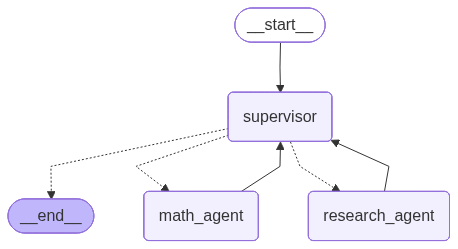

In [17]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [22]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2025.? and What is 2*(3+5)?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Here is the final summary addressing your queries:

1. **US GDP 2025 Forecast**:  
   - OECD: **1.8% growth** (up from 1.6% previously, citing AI investments but slower growth due to tariffs and immigration trends).  
   - Federal Reserve: **1.4% growth** (revised downward from 1.7% in March 2025).  
   - Bloomberg: **3% growth in Q2 2025**, with first-half growth averaging 1.25% (as of July 2025).  

2. **New York State GDP 2025**:  
   No direct forecast was found in recent r